# New Codes

#### install the required libraries

!pip install -r requirements.txt

#### import the required libraries

In [8]:
import glob
import os
import pandas as pd
from datetime import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.widgets import Cursor
%matplotlib inline
import numpy as np
import warnings

# Suppress the specific SettingWithCopyWarning
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

#### boilerplate definitions

In [9]:
# root_dir = os.path.dirname(os.path.abspath(__file__))
root_dir = os.getcwd()
data_dir = os.path.join(root_dir, f'data/')
# pickle_dir = os.path.join(data_dir, 'straddle_pickle_files/')
logs_dir = os.path.join(root_dir,'logs/')
# table_dir = os.path.join(data_dir, 'tables/')
data_path = "W:\Options & Futures Data\Intraday straddle and IV"
dir_list = [data_dir, logs_dir]
status = [os.makedirs(_dir, exist_ok=True) for _dir in dir_list if not os.path.exists(_dir)]

holidays_24 = ['2024-01-22', '2024-01-26', '2024-03-08', '2024-03-25', '2024-03-29', '2024-04-11', '2024-04-17', '2024-05-01', '2024-06-17', '2024-07-17', '2024-08-15', '2024-10-02', '2024-11-01', '2024-11-15', '2024-12-25']
holidays = pd.to_datetime(holidays_24)
excluded_dates = []
if excluded_dates is not None:
    excluded_dates = pd.to_datetime(excluded_dates)
    holidays = holidays[~holidays.isin(excluded_dates)]

b_days = pd.bdate_range(start=pd.to_datetime('2024-05-23'), end=pd.to_datetime(datetime.now().date().strftime('%Y-%m-%d')), holidays=holidays, freq='C', weekmask='1111100').tolist()
pd.set_option('display.max_columns', None) #this would display all the columns of dataframe
# pd.set_option("display.max_rows", None) #this would display all the rows of dataframe

#### defining global df_bids, df_cummulative and business days range

In [10]:
df_cummulative = pd.DataFrame(columns=['Date'])
df_bids=pd.DataFrame(columns=['Date','Straddle_Name','bid','bid_time','bid_price','decay','decay_time','decay_price'])
start_date = str(input('Enter start date in YYYY-MM-DD format:\t'))
start_date = pd.to_datetime(start_date)
end_date = str(input('Enter end date in YYYY-MM-DD format:\t'))
end_date = pd.to_datetime(end_date)
if start_date > end_date:
    raise ValueError('Start date must be less than end date')
use_date_range = [use_date.date() for use_date in b_days if start_date<=use_date<=end_date]

#### df_bids and df_cummulative calculations

In [11]:
def bid_summary(df):
    use_date = df.get('Date').unique()[0]
    straddle_name = df.get('straddle_name').unique()[0]
    dfbid = df.copy()
    dfbid['cummax']=dfbid['Straddle'].cummax()
    dfbid['cummin']=dfbid['Straddle'].cummin()
    dfbid['Bid']=dfbid['Straddle']-dfbid['cummin']
    dfbid['Decay']=dfbid['cummax']-dfbid['Straddle']
    bid=dfbid['Bid'].max()
    decay=dfbid['Decay'].max()
    bid_time=dfbid.loc[dfbid['Bid']==bid].reset_index()['Timestamp']
    bid_price=dfbid.loc[dfbid['Bid']==bid].reset_index()['Straddle']
    decay_price=dfbid.loc[dfbid['Decay']==decay].reset_index()['Straddle']
    decay_time=dfbid.loc[dfbid['Decay']==decay].reset_index()['Timestamp']
    each_row = pd.DataFrame([[use_date,straddle_name,bid,bid_time[0],bid_price[0],decay,decay_time[0],decay_price[0]]],
                columns=['Date','Straddle_Name','bid','bid_time','bid_price','decay','decay_time','decay_price'])
    # df_cummulative = pd.concat([df_cummulative, dfbid])
    dfbid = dfbid.drop(['cummax', 'cummin'], axis=1)
    if bid_time[0] < decay_time[0]:
        start_time = bid_time[0]
        end_time = decay_time[0]
    else:
        start_time = decay_time[0]
        end_time = bid_time[0]
    dfbid = dfbid.query('Timestamp >= @start_time and Timestamp <= @end_time')

    dfbid.sort_values(by=['Decay'], ascending = False, inplace=True)
    return each_row, dfbid

def calc_bid_and_cummulative():
    global df_bids, df_cummulative
    for each_date in use_date_range:
        file_name = f'iv_chart_table_data_{each_date.strftime("%d_%m_%Y")}.csv'
        df = pd.read_csv(os.path.join(data_path, file_name)) # if we have range of dates, then for each date, concat df
        # df_cummulative = pd.DataFrame(columns=['Date'])
        # df_bids=pd.DataFrame(columns=['Date','Straddle_Name','bid','bid_time','bid_price','decay','decay_time','decay_price'])
        df_copy = df.drop(df.columns[~df.columns.isin(set(['timestamp', 'underlying', 'expiry', 'strike', 'combined_premium']))], axis=1).copy()
        df_copy['timestamp'] = pd.to_datetime(df_copy.timestamp)
        df_copy['Date'] = df_copy.timestamp.dt.date.astype(str)
        df_copy['Timestamp'] = df_copy.timestamp.dt.time.astype(str)
        df_copy = df_copy.drop('timestamp', axis=1)
        df_copy.rename(columns = {'combined_premium':'Straddle', 'underlying':'straddle_name'}, inplace=True)
        df_copy = df_copy.reindex(['Date', 'Timestamp', 'straddle_name', 'expiry', 'strike', 'Straddle'], axis=1)
        grouped_df = df_copy.groupby(['Date','straddle_name'])['expiry'].unique().reset_index()

        for index, row in grouped_df.iterrows():
            use_date = row['Date']
            symbol = row['straddle_name']
            exp_list = sorted(row['expiry'])
            for i in range(len(exp_list)):
                each_exp = exp_list[i]
                df1 = df_copy.query('Date == @use_date and straddle_name == @symbol and expiry == @each_exp')
                if i == 0:
                    df1.loc[:,'straddle_name'] = df1['straddle_name'].astype(str) + '_CW'
                elif i == 1:
                    df1.loc[:,'straddle_name'] = df1['straddle_name'].astype(str) + '_NW'
                elif i == 2:
                    df1.loc[:,'straddle_name'] = df1['straddle_name'].astype(str) + '_CM'
                else:
                    df1.loc[:,'straddle_name'] = df1['straddle_name'].astype(str) + '_NM'

                # code to find df_bids and df_cummulative
                try:
                    each_row, dfbid = bid_summary(df1)
                    df_cummulative = pd.concat([df_cummulative, dfbid])
                    df_bids = pd.concat([df_bids, each_row])
                    print(f'{symbol} {each_exp} done')
                except Exception as e:
                    print(f'Error is {e}')
    df_bids.columns = map(str.lower, df_bids.columns)
    df_cummulative.columns = map(str.lower, df_cummulative.columns)
    # no of strikes(col) in df_bids for each straddle_name for each date and expiry
    df_cummulative['strike'] = df_cummulative['strike'].apply(lambda row: int(row))
    bid_date_list = df_bids['date'].unique().tolist()
    strd_name_list = df_bids['straddle_name'].unique().tolist()
    for each_bid_date in bid_date_list:
        for each_strd_name in strd_name_list:
            num_strikes = len(df_cummulative.query("date == @each_bid_date and straddle_name == @each_strd_name"))
            df_bids.loc[(df_bids['date'] == each_bid_date) & (df_bids['straddle_name'] == each_strd_name), 'num_strikes'] = num_strikes
            # ---------------------------------------------------------------------------------------
            st_list = df_cummulative.query("date == @each_bid_date and straddle_name == @each_strd_name")['strike'].unique().tolist()
            st_num = len(st_list)
            st_str = ','.join(map(str, sorted(st_list)))
            df_bids.loc[(df_bids['date'] == each_bid_date) & (df_bids['straddle_name'] == each_strd_name), 'num_strikes'] = st_num
            df_bids.loc[(df_bids['date'] == each_bid_date) & (df_bids['straddle_name'] == each_strd_name), 'distinct_strikes'] = st_str
    df_bids['num_strikes'] = df_bids['num_strikes'].astype(int)
    return df_bids, df_cummulative

In [12]:
df_bids, df_cummulative = calc_bid_and_cummulative()
# print(df_bids)
# print(df_cummulative)

C:\Users\vipulanand\AppData\Local\Temp\ipykernel_16976\2983254949.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_bids = pd.concat([df_bids, each_row])


BANKNIFTY 2024-09-18 done
BANKNIFTY 2024-09-25 done
FINNIFTY 2024-09-17 done
FINNIFTY 2024-09-24 done
MIDCPNIFTY 2024-09-16 done
MIDCPNIFTY 2024-09-23 done
NIFTY 2024-09-19 done
NIFTY 2024-09-26 done
NIFTY 2024-10-31 done
NIFTY 2024-11-28 done
BANKNIFTY 2024-09-18 done
BANKNIFTY 2024-09-25 done
FINNIFTY 2024-09-17 done
FINNIFTY 2024-09-24 done
MIDCPNIFTY 2024-09-16 done
MIDCPNIFTY 2024-09-23 done
NIFTY 2024-09-19 done
NIFTY 2024-09-26 done
NIFTY 2024-10-31 done
NIFTY 2024-11-28 done
BANKNIFTY 2024-09-18 done
BANKNIFTY 2024-09-25 done
FINNIFTY 2024-09-17 done
FINNIFTY 2024-09-24 done
MIDCPNIFTY 2024-09-23 done
MIDCPNIFTY 2024-09-30 done
NIFTY 2024-09-19 done
NIFTY 2024-09-26 done
NIFTY 2024-10-31 done
NIFTY 2024-11-28 done
BANKNIFTY 2024-09-18 done
BANKNIFTY 2024-09-25 done
FINNIFTY 2024-09-24 done
FINNIFTY 2024-10-01 done
MIDCPNIFTY 2024-09-23 done
MIDCPNIFTY 2024-09-30 done
NIFTY 2024-09-19 done
NIFTY 2024-09-26 done
NIFTY 2024-10-31 done
NIFTY 2024-11-28 done
BANKNIFTY 2024-09-25 don

In [14]:
df_cummulative

,date,timestamp,straddle_name,expiry,strike,straddle,bid,decay
3772,2024-09-13,15:30:00,BANKNIFTY_CW,2024-09-18,51900,542.50,0.00,134.10
3752,2024-09-13,15:28:00,BANKNIFTY_CW,2024-09-18,51900,543.95,0.00,132.65
3742,2024-09-13,15:27:00,BANKNIFTY_CW,2024-09-18,51900,546.20,0.00,130.40
3762,2024-09-13,15:29:00,BANKNIFTY_CW,2024-09-18,51900,546.25,2.30,130.35
3621,2024-09-13,15:15:00,BANKNIFTY_CW,2024-09-18,51900,548.50,0.00,128.10
...,...,...,...,...,...,...,...,...
563,2024-09-30,10:10:00,NIFTY_NM,2024-11-28,26900,989.10,38.45,7.40
462,2024-09-30,10:00:00,NIFTY_NM,2024-11-28,26900,991.15,40.50,5.35
553,2024-09-30,10:09:00,NIFTY_NM,2024-11-28,26900,991.20,40.55,5.30
543,2024-09-30,10:08:00,NIFTY_NM,2024-11-28,26900,991.20,40.55,5.30


#### plot graph using df_cummulative

In [15]:
def plot_graph(use_date, strd_name):
    # global df_bids, df_cummulative
    print(f'Your choice => date {use_date}, strd_name {strd_name}')
    dfx = df_cummulative.query('date == @use_date and straddle_name == @strd_name').copy()
    dfx['date_timestamp'] = pd.to_datetime(dfx['date'] + ' ' + dfx['timestamp'])
    df_grouped = dfx.groupby('strike')['decay'].max().reset_index()
    ax = df_grouped.plot(kind = 'bar', x = 'strike', y = 'decay', legend = True, grid = True)
    ax.set_xlabel('Strike')
    ax.set_ylabel('Decay')
    # dfx.plot.bar(x = 'strike', y = 'decay')
    ax.set_title(f'Strike vs Decay for {use_date} {strd_name}')
    # plt.xticks(rotation=45)
    plt.show()

your choice for dates - ['2024-09-13', '2024-09-16', '2024-09-17', '2024-09-18', '2024-09-19', '2024-09-20', '2024-09-23', '2024-09-24', '2024-09-25', '2024-09-26', '2024-09-27', '2024-09-30']
Your choice => date 2024-09-17, strd_name FINNIFTY_CW


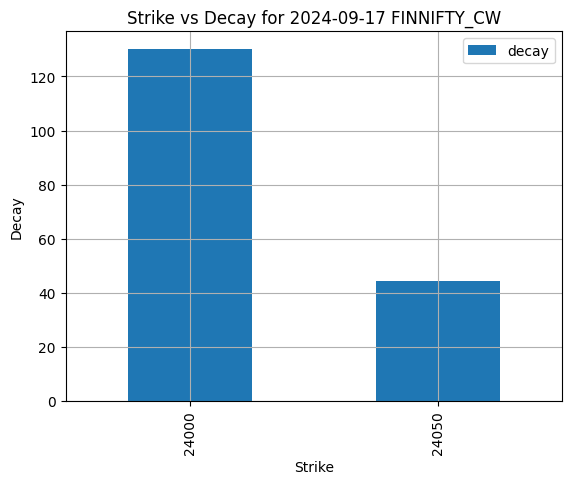

In [16]:
strd_name = str(input('Enter straddle_name(BANKNIFTY_CW, BANKNIFTY_NW etc) for which graph needs to be plotted:\t'))
print(f'your choice for dates - {df_cummulative["date"].unique().tolist()}')
use_date = str(input('Enter date in format - YYYY-MM-DD\t'))
# use_date = pd.to_datetime(use_date)
# strd_name = 'NIFTY_CW' # ca
# use_date = '2024-09-25'
plot_graph(use_date, strd_name)

# print(f'df_bids is \n{df_bids}')
# print(f'df_cummulative is \n{df_cummulative}')